In [14]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.fft import fft, ifft
import os
import pyedflib
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class TimeSeriesDataset(Dataset):
    def __init__(self, df, ws, fourier):
        self.df = df
        self.ws = ws
        self.fourier = fourier
        
        # Извлекаем временные ряды и метки
        self.time_series = df['emb'].values
        self.labels = df['label'].map({'none': 0, 'swd': 1, 'is': 2, 'ds': 3}).values
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.time_series[idx], self.labels[idx]

In [2]:
df = pd.read_parquet('data/data.parquet')
df

,emb,label
0,"[0.050875000000000004, 0.0418125, 0.0518125000...",none
1,"[-0.0885625, -0.1311875, -0.148875, -0.12975, ...",none
2,"[0.185375, 0.2161875, 0.1673125, 0.1468125, 0....",none
3,"[-0.141625, -0.149, -0.1784375, -0.2235, -0.21...",none
4,"[0.21106250000000001, 0.210875, 0.2288125, 0.2...",none
...,...,...
518359,"[0.07981250000000001, 0.079125, 0.0873125, 0.0...",none
518360,"[0.04025, 0.0349375, 0.03625, 0.01325, 0.02162...",none
518361,"[0.07225, 0.063625, 0.0226875, 0.0071875, 0.02...",none
518362,"[0.05375, 0.058875000000000004, 0.08325, 0.096...",none


In [3]:
df['emb'] = df['emb'].map(lambda x: x.reshape((3, -1)))
df['emb']

0         [[0.050875000000000004, 0.0418125, 0.051812500...
1         [[-0.0885625, -0.1311875, -0.148875, -0.12975,...
2         [[0.185375, 0.2161875, 0.1673125, 0.1468125, 0...
3         [[-0.141625, -0.149, -0.1784375, -0.2235, -0.2...
4         [[0.21106250000000001, 0.210875, 0.2288125, 0....
                                ...                        
518359    [[0.07981250000000001, 0.079125, 0.0873125, 0....
518360    [[0.04025, 0.0349375, 0.03625, 0.01325, 0.0216...
518361    [[0.07225, 0.063625, 0.0226875, 0.0071875, 0.0...
518362    [[0.05375, 0.058875000000000004, 0.08325, 0.09...
518363    [[0.0583125, 0.04825, 0.0345625, 0.007125, 0.0...
Name: emb, Length: 518343, dtype: object

In [4]:
df = df[(df['label'] != 'dds') & (df['label'] != 'sdw')]
df

,emb,label
0,"[[0.050875000000000004, 0.0418125, 0.051812500...",none
1,"[[-0.0885625, -0.1311875, -0.148875, -0.12975,...",none
2,"[[0.185375, 0.2161875, 0.1673125, 0.1468125, 0...",none
3,"[[-0.141625, -0.149, -0.1784375, -0.2235, -0.2...",none
4,"[[0.21106250000000001, 0.210875, 0.2288125, 0....",none
...,...,...
518359,"[[0.07981250000000001, 0.079125, 0.0873125, 0....",none
518360,"[[0.04025, 0.0349375, 0.03625, 0.01325, 0.0216...",none
518361,"[[0.07225, 0.063625, 0.0226875, 0.0071875, 0.0...",none
518362,"[[0.05375, 0.058875000000000004, 0.08325, 0.09...",none


# CNN

In [5]:
dataset = TimeSeriesDataset(df, ws=1000, fourier=200)

In [6]:
import copy
import datetime
import random
import traceback

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [7]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0, 
                    plot=False):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

# Dynamic plot
    if plot:
        plot_epoch_data = []
        plot_train_loss = []
        plot_val_loss = []

        fig, ax = plt.subplots()
        line_train, = ax.plot([], [], 'r-')
        line_val, = ax.plot([], [], 'b-')
        ax.legend(['train', 'val'])
        ax.set_xlim(0, epoch_n)

        def add_point(epoch_i, train_loss, val_loss):
            max_loss = max(ax.viewLim.y1 / 1.1, train_loss, val_loss)
            ax.set_ylim(0, max_loss * 1.1)
            
            plot_epoch_data.append(epoch_i)
            plot_train_loss.append(train_loss)
            plot_val_loss.append(val_loss)
            line_train.set_data(plot_epoch_data, plot_train_loss)
            line_val.set_data(plot_epoch_data, plot_val_loss)
            clear_output(wait=True)
            display(fig)


    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            

            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)
                    print("batch_train", float(loss))
                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n

            if plot:
                add_point(epoch_i, mean_train_loss, mean_val_loss)
            else:
                pass
            
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель! На эпохе {}'.format(epoch_i))
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
        finally:
            if plot:
                plt.close(fig)

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class CNN1d(nn.Module):
    def __init__(self, channels_in = 3, ws = 1000):
        super(CNN1d, self).__init__()
        self.act = nn.GELU()
        self.conv11 = nn.Conv1d(in_channels=channels_in, 
                               out_channels=64,
                               kernel_size=100,
                               padding=1,
                               padding_mode='circular',
                               bias=False)
        self.bn11 = nn.BatchNorm1d(64)
        self.conv12 = nn.Conv1d(in_channels=64, 
                               out_channels=128,
                               kernel_size=100,
                               padding=1,
                               padding_mode='circular',
                               bias=False)
        self.bn12 = nn.BatchNorm1d(128)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv21 = nn.Conv1d(in_channels=128, 
                               out_channels=128,
                               kernel_size=3,
                               padding=1,
                               padding_mode='zeros',
                               bias=False)
        self.bn21 = nn.BatchNorm1d(128)
        self.conv22 = nn.Conv1d(in_channels=128, 
                               out_channels=128,
                               kernel_size=3,
                               padding=1,
                               padding_mode='zeros',
                               bias=False)
        self.bn22 = nn.BatchNorm1d(128)
        self.adaptive_pool = nn.AvgPool1d(kernel_size=100)
        self.fc = nn.Linear(256, 4)

        self.wavelets = nn.Sequential(
            self.conv11,
            self.act,
            self.bn11,
            self.conv12,
            self.act,
            self.bn12
        )

        self.encoder = nn.Sequential(
            self.conv21,
            self.act,
            self.pool,
            self.bn21,
            self.conv22,
            self.act,
            self.pool,
            self.bn22,
            self.adaptive_pool
        )

    def forward(self, data):
        x = data.type(torch.cuda.FloatTensor)
        x = self.wavelets(x)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
model = CNN1d()

In [11]:
train_dataset = df[:int(0.85 * len(df))]
val_dataset = df[int(0.85 * len(df)):]

train_dataset = TimeSeriesDataset(train_dataset, ws=1000, fourier=400)
val_dataset = TimeSeriesDataset(val_dataset, ws=1000, fourier=400)

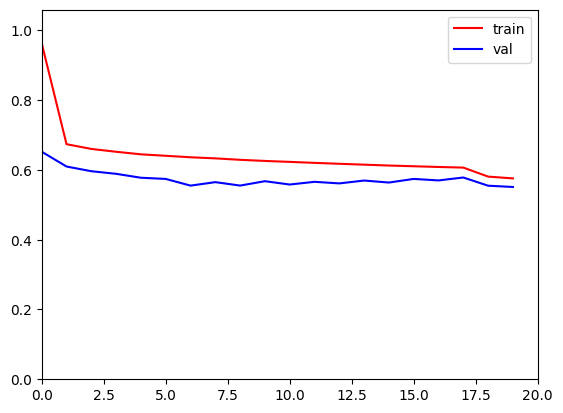

Среднее значение функции потерь на валидации 0.5510957473172591
Новая лучшая модель! На эпохе 19



In [12]:
best_loss, best_model = train_eval_loop(model=model, 
                train_dataset=train_dataset, 
                val_dataset=val_dataset, 
                criterion=nn.CrossEntropyLoss(),
                lr=1e-3, 
                epoch_n=20, 
                batch_size=3000,
                device="cuda:0" if torch.cuda.is_available() else "cpu", 
                early_stopping_patience=20, 
                l2_reg_alpha=0.15,
                max_batches_per_epoch_train=10000,
                max_batches_per_epoch_val=1000,
                data_loader_ctor=DataLoader,
                optimizer_ctor=torch.optim.Adam,
                lr_scheduler_ctor=torch.optim.lr_scheduler.ReduceLROnPlateau,
                shuffle_train=False,
                dataloader_workers_n=1, plot=True)

# Metrics

In [15]:
file_name = 'data/golden/Ati4x1_15m_H2O_6h_edited.edf'
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
n_a = f.annotations_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

In [16]:
annotations = list(f.readAnnotations())
annotations[0] = annotations[0] / (f.getFileDuration() / sigbufs.shape[1])
annotations

[array([ 171400.,  184180., 2698120., 2705430., 2874740., 2879860.,
        5692550., 5716010., 8002510., 8038110., 8059800., 8090150.,
        8090190., 8098990.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.]),
 array(['ds1', 'ds2', 'is1', 'is2', 'is1', 'is2', 'ds1', 'ds2', 'ds1',
        'ds2', 'ds1', 'ds2', 'is1', 'is2'], dtype='<U3')]

In [17]:
def jaccard_metric(data, ground_trouth):
    gr = []
    d = []
    if 'is' in ground_trouth:
        gr.append(np.array(ground_trouth) == 'is')
        d.append(np.array(data) == 'is')
        
    
    if 'ds' in ground_trouth:
        gr.append(np.array(ground_trouth) == 'ds')
        d.append(np.array(data) == 'ds')
    
    if 'swd' in ground_trouth:
        gr.append(np.array(ground_trouth) == 'swd')
        d.append(np.array(data) == 'swd')
    
    gr.append(np.array(ground_trouth) == 'none')
    d.append(np.array(data) == 'none')
    
    result = 0
    for i in range(len(d)):
        result += jaccard_score(gr[i], d[i])
    
    return result/len(d)

In [ ]:
result = []

for i in tqdm(range(0, len(sigbufs[0]), 100)):
    if i + 1000 < len(sigbufs[0]):
        data = best_model([sigbufs[:, i: i+1000]])
        mode = data.argmax()
        result.append([data.argmax(), i+900])